<a href="https://colab.research.google.com/github/polkadot21/cyberwest/blob/master/Min_Max_Classifier_05/13/2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

import plotly.express as px
import plotly.graph_objects as go

In [0]:
#random array, x[0] = 1, 
#x[i] = x[i-1] + random.uniform(-1, 1)
def random_array(M):
    #random.seed(42)
    N=1024
    x = range(N)
    y = np.zeros(N*M)
    y[0] = 1
    for i in range(1, N*M):
        y[i] = y[i-1] + random.uniform(-1, 1)
    
    return y

In [0]:
#local maxima/minima of random_array M*1024 
#with distance between extrema > 3
#changing MAXs and MINs
#with T*std so that there are approx. 10 extrema in N=1024

def extrema(arr):
    #arr = random_array(M)
    #flag variable
    found_min = False
    found = False
    #1/4 of std 
    x = 3
    T = 0.05
    Y_last = 0
    #distance between extrema >3
    dist = x+1
    Ymax = np.zeros(len(arr))
    Ymin = np.zeros(len(arr))
    #T*std
    #D = T*np.std(arr[:-(len(arr)-1)] - arr[0:])
    D = 0
    for i in range(1, len(arr)-1):
        #print(D)
        #dist > 3 
        if dist > x:
            #decides to start with MAX or MIN at the beginning of the search
            if found_min or not found:
                if arr[i] > arr[i-1] and arr[i] > arr[i+1]:
                    #whether or not the difference between the last extremum and a new one is more than T.std
                    if np.abs(arr[i] - Y_last) >=D:
                        dist = 1
                        Ymax[i] = 1
                        found = True
                        found_min = False
                        Y_last = arr[i]
                        D = T*np.std(arr[:-(len(arr)-1)] - arr[0:])
                    else:
                        i+=1
                    
            if not found_min or not found:
                if arr[i] < arr[i-1] and arr[i] < arr[i+1]:
                    if np.abs(arr[i] - Y_last) >= D:
                        dist = 1
                        Ymin[i] = 2
                        found = True
                        found_min = True
                        Y_last = arr[i]
                        D = T*np.std(arr[:-(len(arr)-1)] - arr[0:])
                    else:
                        i+=1
        else:
            dist+=1
    #Y_mean = the number of extrema in N=1024       
    Y = Ymax+Ymin
    Ynum = (np.sum(Ymax) + np.sum(Ymin))*1024/(2*len(arr))
    print (len(arr))
    return Ymax, Ymin, Y, Ynum

In [202]:
#M = 1000
x = random_array(100)
X = x.reshape(-1, 1)
ymax, ymin, y, num = extrema(x)

102400


In [203]:
num

10.035

In [0]:
# -------- Train - Test-------
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# ---------Split train into train-val--------
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [0]:
#-----Scale-----
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [207]:
#-----SMOTE-------
X_resampled, y_resampled = sm.fit_sample(X_train, y_train.ravel())

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [0]:
#class_dist for each class
def get_class_distribution(obj):
    count_dict = {
        "no": 0,
        "max": 0,
        "min": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['no'] += 1
        elif i == 1: 
            count_dict['max'] += 1
        elif i == 2: 
            count_dict['min'] += 1
                   
        else:
            print("Check classes.")
            
    return count_dict

In [231]:
print("Train:", get_class_distribution(y_resampled))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'no': 72765, 'max': 72765, 'min': 72765}
Test : {'no': 20212, 'max': 134, 'min': 134}
Val  : {'no': 8085, 'max': 53, 'min': 54}


Text(0.5, 1.0, 'Class Distribution in Test Set')

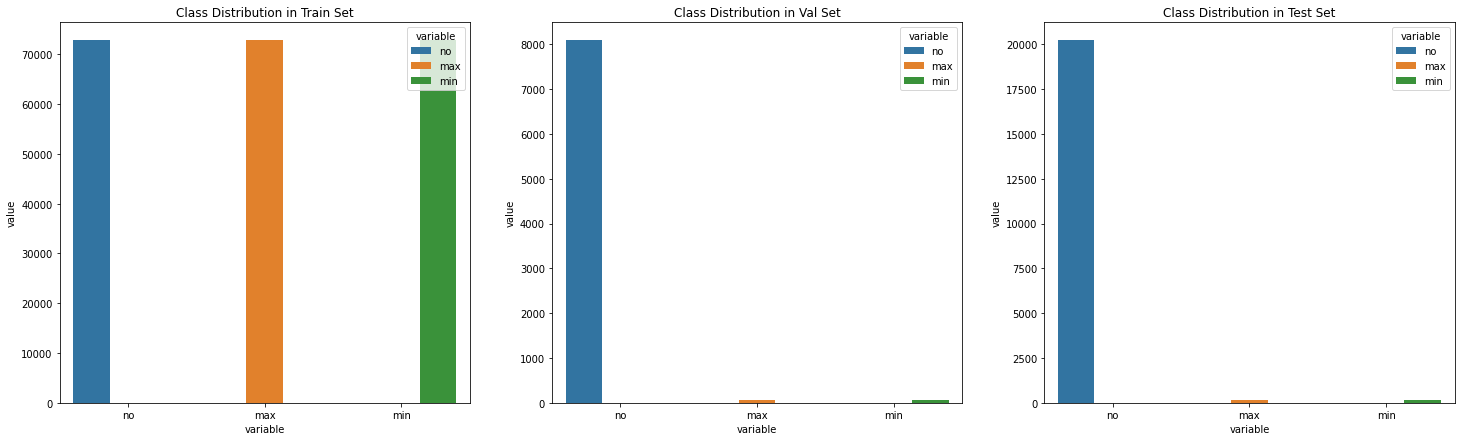

In [232]:
#plot class dist 
#y_train after resampling

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_resampled)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


In [0]:

class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(
    torch.from_numpy(X_resampled).float(),
    torch.from_numpy(y_resampled).long()
                                  )
val_dataset = ClassifierDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(y_val).long()
    )
test_dataset = ClassifierDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(y_test).long()
    )

In [0]:

target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [235]:
class_count = [i for i in get_class_distribution(y_resampled).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([1.3743e-05, 1.3743e-05, 1.3743e-05])

In [0]:
class_weights_all = class_weights[target_list]

In [0]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [0]:
#params

EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

NUM_FEATURES = 1
NUM_CLASSES = 3

In [0]:
#loader

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [0]:
class Min_Max_Classification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(Min_Max_Classification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 16)
        #self.layer_2 = nn.Linear(64, 32)
        #self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(16)
        #self.batchnorm2 = nn.BatchNorm1d(32)
        #self.batchnorm3 = nn.BatchNorm1d(16)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        #x = self.layer_2(x)
        #x = self.batchnorm2(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        
        #x = self.layer_3(x)
        #x = self.batchnorm3(x)
        #x = self.relu(x)
        #x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [241]:
#cpu and gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [242]:
#set model, 
#gpu/cpu
model = Min_Max_Classification(
    num_feature = NUM_FEATURES,
    num_class=NUM_CLASSES)
model.to(device)

print(model)

#multiclass critretion
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Min_Max_Classification(
  (layer_1): Linear(in_features=1, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [0]:
#accuracy

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

In [0]:

accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [245]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.09963 | Val Loss: 1.02866 | Train Acc: 5.167| Val Acc: 87.939
Epoch 002: | Train Loss: 1.09914 | Val Loss: 1.07957 | Train Acc: 5.050| Val Acc: 35.596
Epoch 003: | Train Loss: 1.09910 | Val Loss: 1.08295 | Train Acc: 5.585| Val Acc: 76.721
Epoch 004: | Train Loss: 1.09888 | Val Loss: 1.10668 | Train Acc: 5.834| Val Acc: 7.300
Epoch 005: | Train Loss: 1.09887 | Val Loss: 1.08974 | Train Acc: 5.753| Val Acc: 40.881
Epoch 006: | Train Loss: 1.09885 | Val Loss: 1.08738 | Train Acc: 5.724| Val Acc: 16.724
Epoch 007: | Train Loss: 1.09866 | Val Loss: 1.04333 | Train Acc: 5.797| Val Acc: 73.621
Epoch 008: | Train Loss: 1.09852 | Val Loss: 1.08128 | Train Acc: 6.237| Val Acc: 56.824
Epoch 009: | Train Loss: 1.09853 | Val Loss: 1.11064 | Train Acc: 5.805| Val Acc: 18.616
Epoch 010: | Train Loss: 1.09854 | Val Loss: 1.09527 | Train Acc: 5.951| Val Acc: 51.514



Text(0.5, 1.0, 'Train-Val Loss/Epoch')

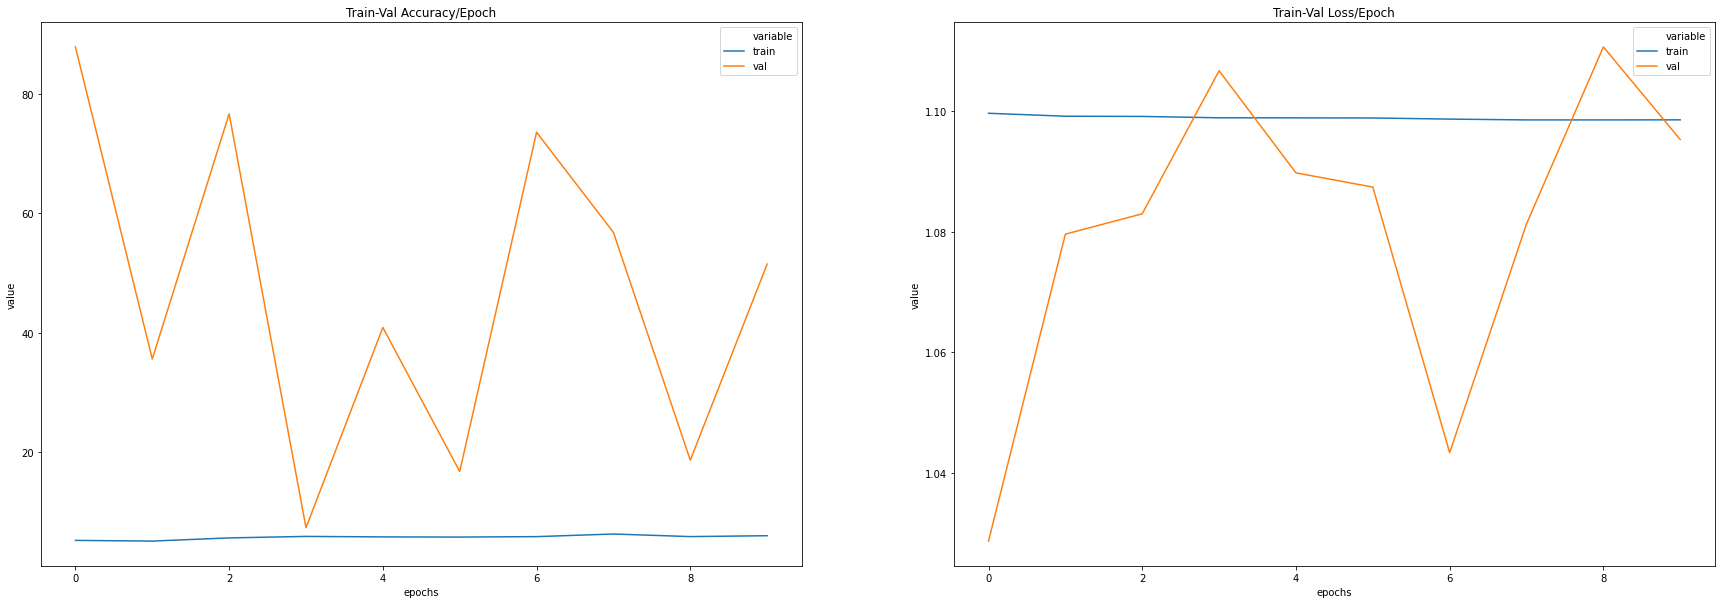

In [246]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [0]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

In [0]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]


In [249]:

0 in y_pred_list

True

In [250]:
print(confusion_matrix(y_test, y_pred_list))

[[10440  5880  3892]
 [   72    36    26]
 [   57    48    29]]


In [251]:
print(classification_report(y_test, y_pred_list, target_names=["0", "1","2"]))


              precision    recall  f1-score   support

           0       0.99      0.52      0.68     20212
           1       0.01      0.27      0.01       134
           2       0.01      0.22      0.01       134

    accuracy                           0.51     20480
   macro avg       0.33      0.33      0.23     20480
weighted avg       0.97      0.51      0.67     20480



In [0]:
#make a random sample of length M*N
#print confusion matrix
def out_of_sample(M):
    x_sample = random_array(M)
    ymax_sample, ymin_sample, ymean_sample , y_sample = extrema(x_sample, M)
    
    X_sample = x_sample.reshape(-1, 1)
    X_sample = scaler.transform(X_sample)
    
    sample_dataset = ClassifierDataset(torch.from_numpy(X_sample).float(),
                                    torch.from_numpy(y_sample).long())
    
    sample_loader = DataLoader(dataset=sample_dataset, batch_size=1)
    
    y_pred_list_sample = []

    with torch.no_grad():
        model.eval()
        for X_batch, _ in sample_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            y_pred_list_sample.append(y_pred_tags.cpu().numpy())
            
    print(confusion_matrix(y_sample, y_pred_list_sample))
    return np.asarray(x_sample), np.asarray(y_pred_list_sample), np.asarray(y_sample)

In [0]:
#plot sample
#plot real extrema (blue)
#Plot predicted extrema (red)

def plot_out_of_sample(M, n=1024):
    #create a sample
    x_sample, y_pred, y_real = out_of_sample(M)
    #reshape predicted
    y_pred = np.reshape(y_pred, len(y_pred))
    t = np.linspace(0, n)
    y1 = x_sample
    y2 = y_real
    y3 = y_pred
    
    
    fig = go.Figure()

    # Add traces
    
                  
    fig.add_trace(go.Scatter(x=t, y=y1,
                    mode='lines+markers',
                    name='array_sample',
                    marker_color='rgb(154, 221, 43)'))
                  
    fig.add_trace(go.Scatter(x=t, y=y2,
                        mode='markers',
                        name='Y_real',
                        marker_color='rgb(0, 191, 255)'))
    
    fig.add_trace(go.Scatter(x=t, y=y3,
                    mode='markers',
                    name='Y_pred',
                    marker_color='rgb(253, 68, 43)'))


    return fig.show()

In [0]:
plot_out_of_sample(10)

ValueError: ignored